In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from hmmlearn.hmm import GaussianHMM

# ---------------------------------------------------------
# Basic setup (editable)
# ---------------------------------------------------------
asset_symbol = "SPY"        # e.g. "AAPL", "TSLA", "^NSEI", "SPY"
lookback_period = "10y"
data_gap = "1d"

num_hidden_states = 2
seed_val = 42


In [2]:
# ---------------------------------------------------------
# Fetch historical price data for the selected asset
# ---------------------------------------------------------
price_data = yf.download(
    asset_symbol,
    period=lookback_period,
    interval=data_gap
)

# Yahoo Finance provides already-adjusted prices,
# so we just keep the regular "Close" column and rename it.
price_data = price_data[["Close"]].copy()
price_data.rename(columns={"Close": "Adj_Close"}, inplace=True)

price_data.head()


/var/folders/zc/y9y4f8bd675dpzv7qn8jtwrw0000gn/T/ipykernel_19677/2011601279.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  price_data = yf.download(
[*********************100%***********************]  1 of 1 completed


Price,Adj_Close
Ticker,SPY
Date,
2015-11-23,176.667023
2015-11-24,176.903610
2015-11-25,176.878250
2015-11-27,177.081100
2015-11-30,176.345947


In [3]:
# ---------------------------------------------------------
# Compute daily log-returns from adjusted closing prices
# ---------------------------------------------------------
price_data["log_ret"] = np.log(price_data["Adj_Close"]).diff()

# Remove the first row (NaN after differencing)
price_data = price_data.dropna()

price_data.head()


Price,Adj_Close,log_ret
Ticker,SPY,
Date,,
2015-11-24,176.903610,0.001338
2015-11-25,176.878250,-0.000143
2015-11-27,177.081100,0.001146
2015-11-30,176.345947,-0.004160
2015-12-01,178.027481,0.009490


In [4]:
# ---------------------------------------------------------
# Prepare return sequence for the HMM (1D feature)
# ---------------------------------------------------------
returns_series = price_data["log_ret"].to_numpy().reshape(-1, 1)

# ---------------------------------------------------------
# Build and train a Gaussian Hidden Markov Model
# ---------------------------------------------------------
hmm_model = GaussianHMM(
    n_components=num_hidden_states,
    covariance_type="diag",
    n_iter=200,
    random_state=seed_val
)

hmm_model.fit(returns_series)

# Hidden state assignments + posterior probabilities
hidden_seq = hmm_model.predict(returns_series)
log_lik, post_probs = hmm_model.score_samples(returns_series)

# ---------------------------------------------------------
# Display model parameters
# ---------------------------------------------------------
print("State Means:", hmm_model.means_.flatten())
print("State Variances:", hmm_model.covars_.flatten())
print("\nTransition Probabilities:")
print(hmm_model.transmat_)


State Means: [ 0.00113233 -0.00138749]
State Variances: [4.87342406e-05 4.13166592e-04]

Transition Probabilities:
[[0.98495051 0.01504949]
 [0.04704162 0.95295838]]


In [5]:
# ---------------------------------------------------------
# Attach the inferred hidden state to the price dataframe
# ---------------------------------------------------------
price_data["Regime"] = hidden_seq

price_data.tail()


Price,Adj_Close,log_ret,Regime
Ticker,SPY,,
Date,,,
2025-11-17,665.669983,-0.009360,0
2025-11-18,660.080017,-0.008433,0
2025-11-19,662.630005,0.003856,0
2025-11-20,652.530029,-0.015360,0
2025-11-21,659.030029,0.009912,0


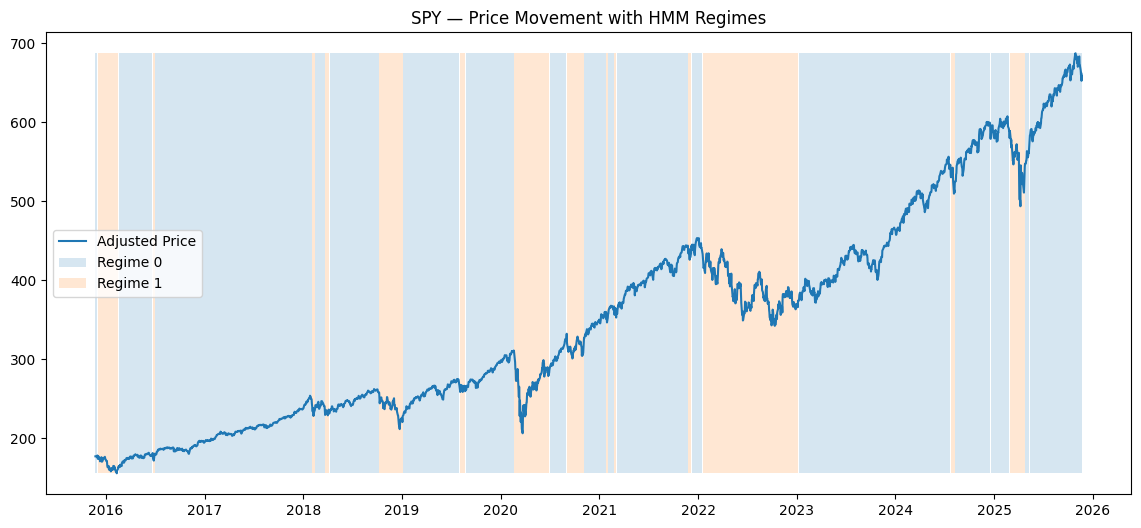

In [6]:
# ---------------------------------------------------------
# Visualize price series along with inferred market regimes
# ---------------------------------------------------------
plt.figure(figsize=(14, 6))
plt.plot(price_data.index, price_data["Adj_Close"], label="Adjusted Price")

# Shade areas corresponding to each hidden state
for state_id in range(num_hidden_states):
    zone = price_data["Regime"] == state_id
    plt.fill_between(
        price_data.index,
        price_data["Adj_Close"].min(),
        price_data["Adj_Close"].max(),
        where=zone,
        alpha=0.18,
        label=f"Regime {state_id}"
    )

plt.title(f"{asset_symbol} — Price Movement with HMM Regimes")
plt.legend()
plt.show()


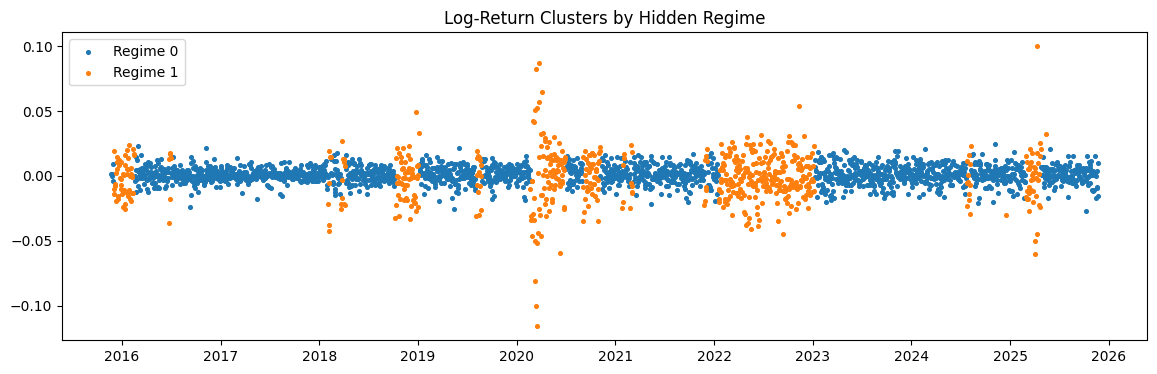

In [7]:
# ---------------------------------------------------------
# Scatter plot of log-returns colored by inferred HMM state
# ---------------------------------------------------------
plt.figure(figsize=(14, 4))

for regime_id in range(num_hidden_states):
    pts = price_data["Regime"] == regime_id
    plt.scatter(
        price_data.index[pts],
        price_data["log_ret"][pts],
        s=7,
        label=f"Regime {regime_id}"
    )

plt.title("Log-Return Clusters by Hidden Regime")
plt.legend()
plt.show()


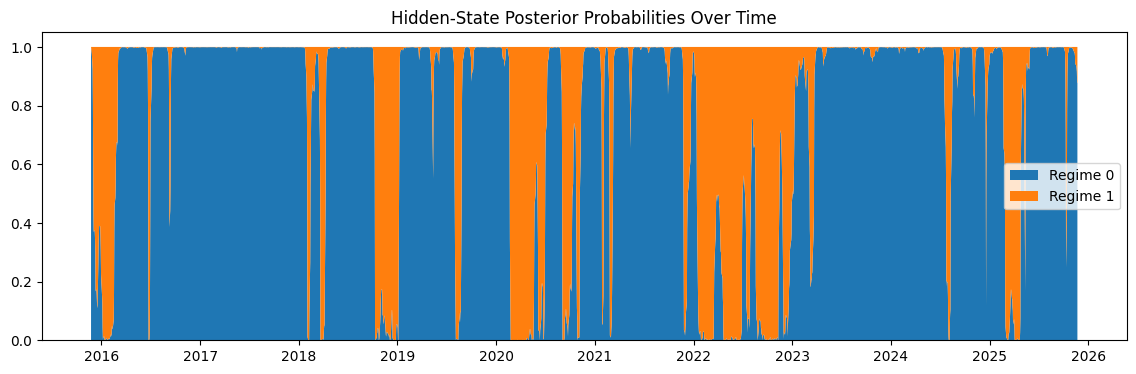

In [8]:
# ---------------------------------------------------------
# Plot the model's posterior probability for each regime
# ---------------------------------------------------------
plt.figure(figsize=(14, 4))

plt.stackplot(
    price_data.index,
    post_probs.T,
    labels=[f"Regime {r}" for r in range(num_hidden_states)]
)

plt.title("Hidden-State Posterior Probabilities Over Time")
plt.legend()
plt.show()


In [9]:
# ---------------------------------------------------------
# Estimate the probability distribution for tomorrow's regime
# ---------------------------------------------------------
latest_posterior = post_probs[-1]          # last day's posterior vector
predicted_probs = latest_posterior @ hmm_model.transmat_

print("Estimated probabilities for the upcoming state:")
for rid, prob in enumerate(predicted_probs):
    print(f"Regime {rid}: {prob:.4f}")

print("\nMost probable next regime:", np.argmax(predicted_probs))


Estimated probabilities for the upcoming state:
Regime 0: 0.8705
Regime 1: 0.1295

Most probable next regime: 0


In [10]:
# ---------------------------------------------------------
# Export the dataset along with inferred regimes
# ---------------------------------------------------------
output_name = f"{asset_symbol}_regime_output.csv"
price_data.to_csv(output_name)

price_data.head()
print(f"File successfully written: {output_name}")


File successfully written: SPY_regime_output.csv
